In [1]:
from ipynb.fs.defs.Preprocessing_Module import read_data, add_topological, add_landcover, merge_new_data, fill_data, select_columns, reshape_dataset, fillna_dataset, remove_nan_features, unused_stations
from ipynb.fs.defs.Feature_Expansion_Module import feature_expansion
from ipynb.fs.defs.Initializer_Module import initializer
from ipynb.fs.defs.XGboost_Model_Module import Xgboost_model
from ipynb.fs.defs.Neural_Network_Module import FeedforwardNeuralNetModel
from ipynb.fs.defs.Model_Validation_Module import give_predictions_nn, evaluate_nn, give_predictions_xgboost, evaluate_xgboost, validate_results, merge_predictions
import numpy as np
import pandas as pd

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [3]:
data = read_data('../Datasets/Greece/GRE_culex_2011_2023.csv')
data = merge_new_data('../Datasets/Greece/monthly_data/GRE_culex_ento_2024_09_processed.csv', data)
data = merge_new_data('../Datasets/Greece/monthly_data/GRE_env_2024_10_2km_processed.csv', data)
#=====================================================================
data = data[(data.nuts2_name == 'CENTRAL MACEDONIA') | (data.nuts2_name == 'Π. ΚΕΝΤΡΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ')] 
data = data.reset_index(drop=True)
#=====================================================================
columns = ['dt_placement', 'x', 'y', 'culex spp.', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/greece_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/greece_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['trap_id', 'station_id', 'x', 'y', 'dt_placement', 'week', 'month',
       'year', 'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code',
       'nuts1_name', 'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type', 'culex spp.',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7',
       'dt_placement_minus_14', 'dt_placement_m

In [4]:
# set the date of prediction for the test set
date = '2024-10-01'

# set the filename for export
case = 'Culex_Greece_CM_'

# set the filename to export
path = './predictions/Greece/Central_Macedonia/'

# title = date[:-3].replace(date[:-3][-1],str(int(date[:-3][-1])+1)).replace('-','_')
title = date[:-3].replace('-','_')
title = case + title

# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'class_regression'

In [5]:
data = feature_expansion(data)

In [6]:
data = initializer(data, model_type, 10)

Bounds: [    0.      4.     12.     24.     43.     71.    124.    208.    355.
   684.4 10458. ]


In [7]:
print("#===========================================")
print("Performance of the previous month")
print("#===========================================")
print()
validate_results(path+case + date[:-3].replace(date[:-3].split('-')[1],str(int(date[:-3].split('-')[1])-1)).replace('-','_')+'.csv',data)

#===========================================
Performance of the previous month
#===========================================

Mean time difference in days: 0.46
-------------------
Overall MAE: 1.86
Overall % error <=3: 90.0
number of observations: 50
-------------------
MAE without entomological: 1.86
% error <=3 without entomological: 90.0
number of observations: 50
-------------------


In [9]:
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================

# Spit to train and test based on date of predictions
test = data.loc[data[date_col] >= pd.to_datetime(date)]
data = data.loc[data[date_col] < pd.to_datetime(date)]

# Delete from test set stations that are not used during the last 3 years
# test = unused_stations(data, test, period=3)

#Remove features that are more 40% filled with nan values in the test set
data, test = remove_nan_features(data, test, 0.4)

# set the only_env as True if there are no mosquitoes for the forecast month
only_env=None    
if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
    only_env=False
elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
    only_env=True
else:
    print('No data left for prediction')
    
num_class = 1
hidden_layers = [264,128,128,64,32]
learning_rate = 0.001
epochs = 50
batch_size = 128
dropout = 0.2
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = ['scaling']
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance (!very time consuming!)
fi = False
    
if only_env != None:
    # Run first without entomological features
    print("#===========================================")
    print("Predictions without entomological features")
    print("#===========================================")
    print()
    data_env = data.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)

    data_env = data_env.dropna().reset_index(drop=True)
    test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)

    
    model = FeedforwardNeuralNetModel(num_features=len(data_env.iloc[0,:])-2, num_class=num_class,
                                      hidden_layers = hidden_layers, model_type=model_type,
                                      learning_rate = learning_rate, epochs = epochs, batch_size = batch_size,
                                      dropout = dropout, embedding_data=embedded_data, 
                                      transformation_list=transformation_list, early_stop = early_stop, 
                                      l1_weight=0, l2_weight=0, weights=False)

    evaluate_nn(model, data_env, fi = fi)

    predictions_env = give_predictions_nn(model, data_env, test_env, env = True, filepath = path, case = title,
                                          export = only_env)

    # Run with entomological features if at least one station has mosquitos number
    if not only_env:
        print("#===========================================")
        print("Predictions with entomological features")
        print("#===========================================")
        print()
        
        data_entom = data.dropna().reset_index(drop=True)
        test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        model = FeedforwardNeuralNetModel(num_features=len(data_entom.iloc[0,:])-2, num_class=num_class,
                                          hidden_layers = hidden_layers, model_type=model_type,
                                          learning_rate = learning_rate, epochs = epochs, batch_size = batch_size,
                                          dropout = dropout, embedding_data=embedded_data, 
                                          transformation_list=transformation_list, early_stop = early_stop, 
                                          l1_weight=0, l2_weight=0, weights=False)
        
        evaluate_nn(model, data_entom, fi = fi)

        predictions_entom = give_predictions_nn(model, data_entom, test_entom, env = False, filepath = path,
                                                case = title, export = False)

        print("#===========================================")
        print("Predictions with/without entomological features")
        print("#===========================================")
        merge_predictions(predictions_env,predictions_entom,path,title,export=True)

No data left for prediction


#===========================================
Predictions without entomological features
#===========================================



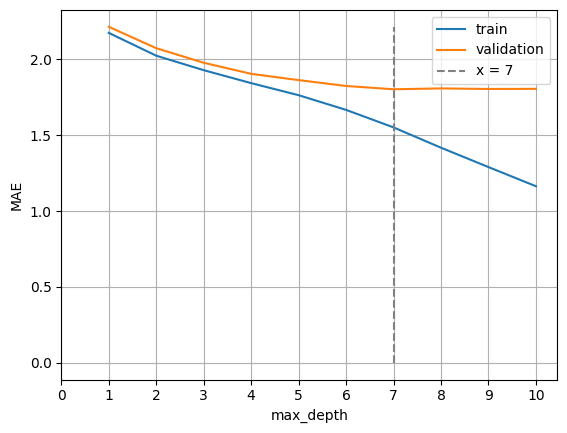

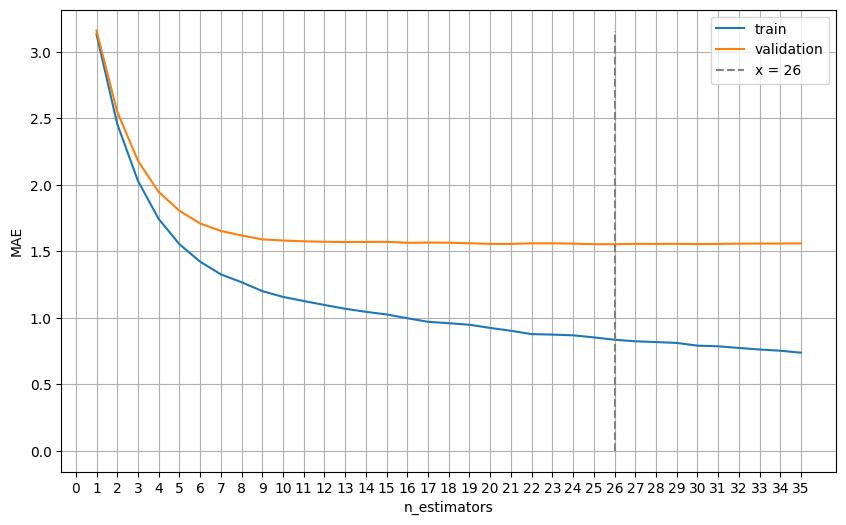

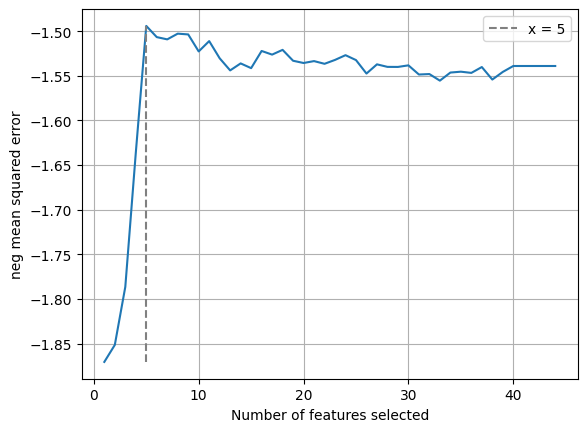

max_depth:  7
Number of estimators:  26
Selected_features:  Index(['DISTANCE_TO_COAST', 'ELEVATION_mean_1km', 'null_island_distance',
       'days_distance', 'year'],
      dtype='object')
MAE on train set:  1.077176403207331
min prediction: -0.0
max prediction: 9.0

MAE on test set:  1.5386376645678306
Error <= 3: 91.30 %
min prediction: 0.0
max prediction: 9.0


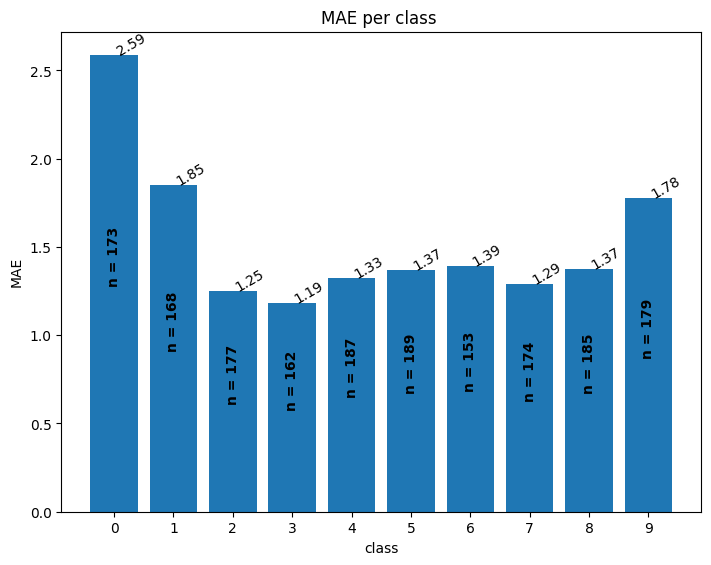

-----------|class error-MAE| difference-----------
mean: 0.41406349238685036
std: 0.22321676222202858
coefficient of variation (std/mean): 0.5390882469142729

----------normalized difference-------------
mean: 0.5092661914665023
std: 0.2745394183703852


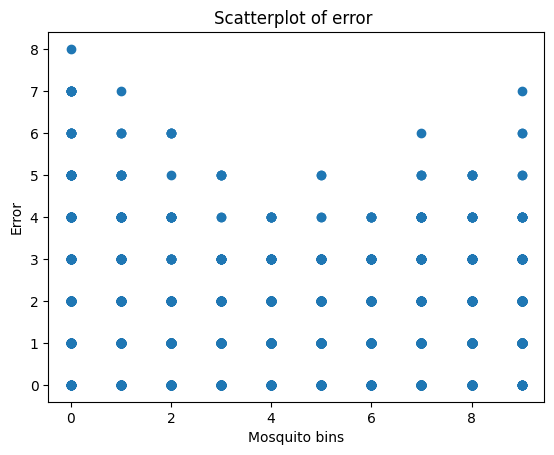

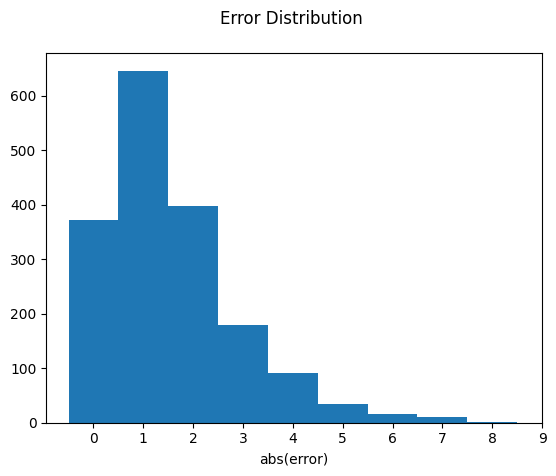

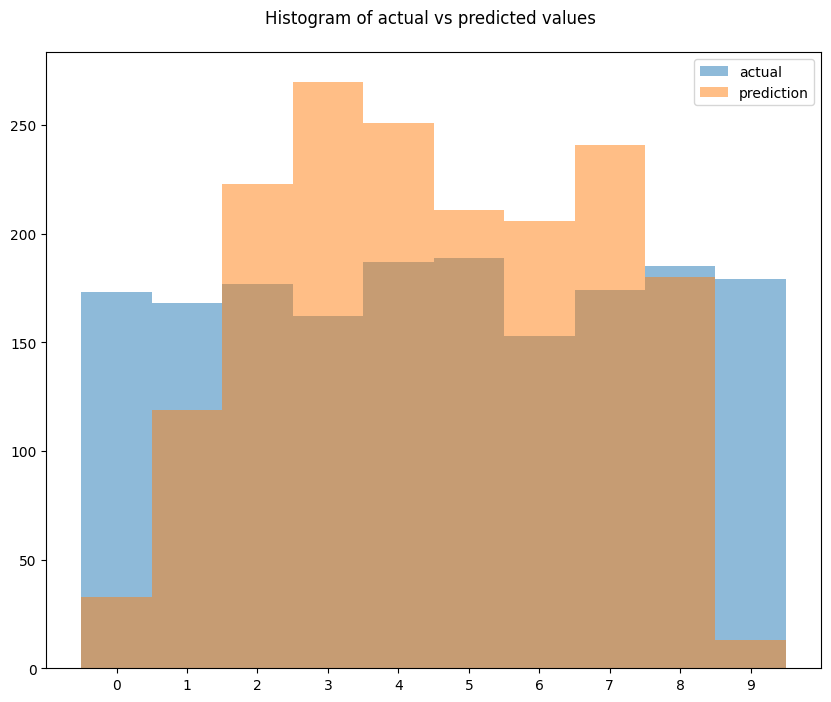

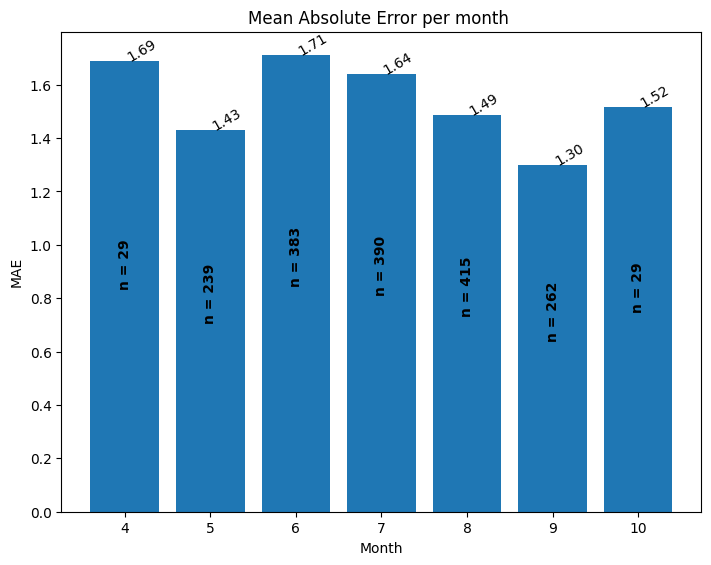

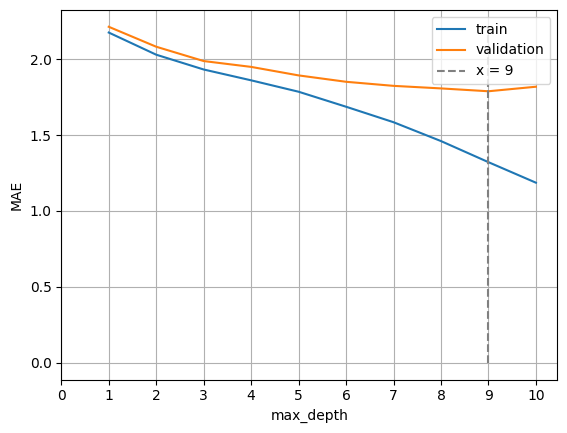

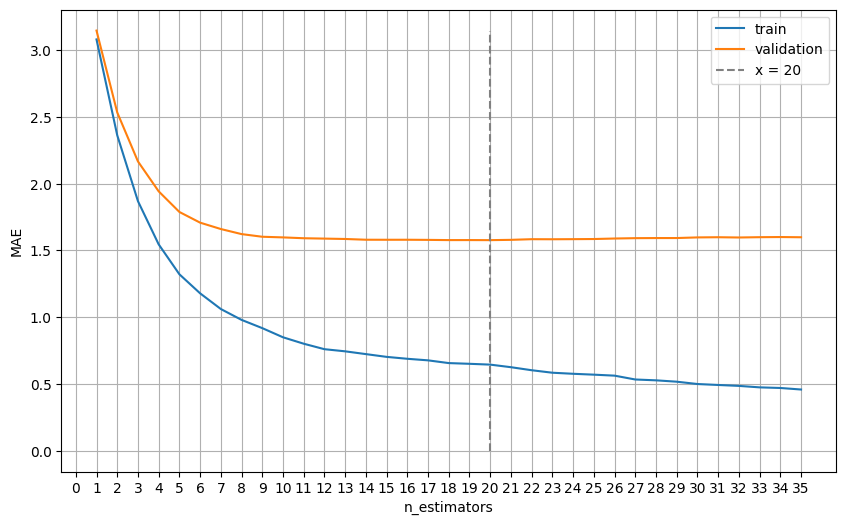

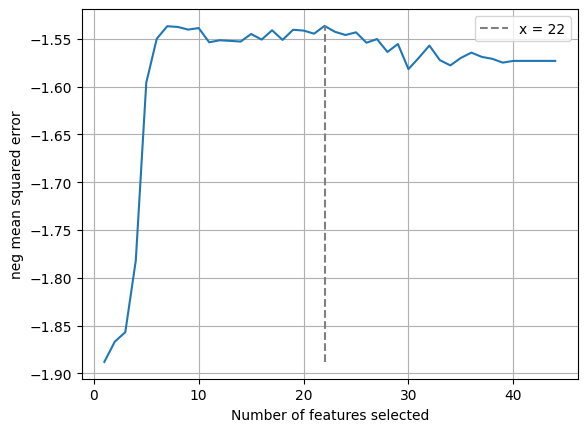

max_depth:  9
Number of estimators:  20
Selected_features:  Index(['lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean',
       'lst_apr_day_mean', 'lst_jan_night_mean', 'lst_feb_night_mean',
       'lst_mar_night_mean', 'lst_apr_night_mean', 'DISTANCE_TO_COAST',
       'DISTANCE_TO_RIVER', 'SLOPE_mean_1km', 'ASPECT_mean_200m',
       'ELEVATION_mean_1km', 'HILLSHADE_mean_1km', 'FLOW_ACCU_200m',
       'landcover', 'null_island_distance', 'days_distance', 'mo_cos', 'year',
       'lst', 'summer_days_month'],
      dtype='object')
prediction
-0.0     505
 1.0    1222
 2.0    1204
 3.0    1148
 4.0     704
 5.0     224
 6.0      16
 7.0       2
Name: count, dtype: int64

Low risk category stations: 1727
Medium risk category stations: 3280
High risk category stations: 18
#===========================================
Predictions with entomological features
#===========================================



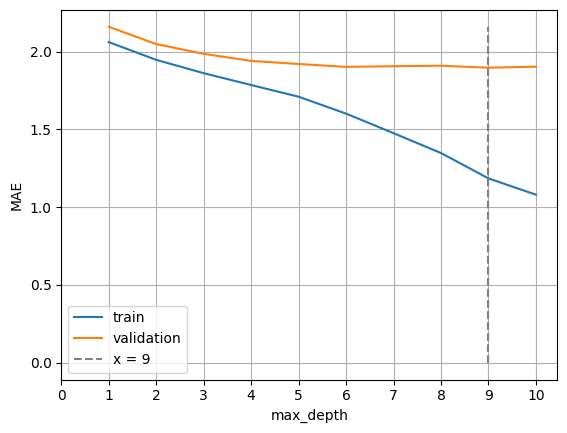

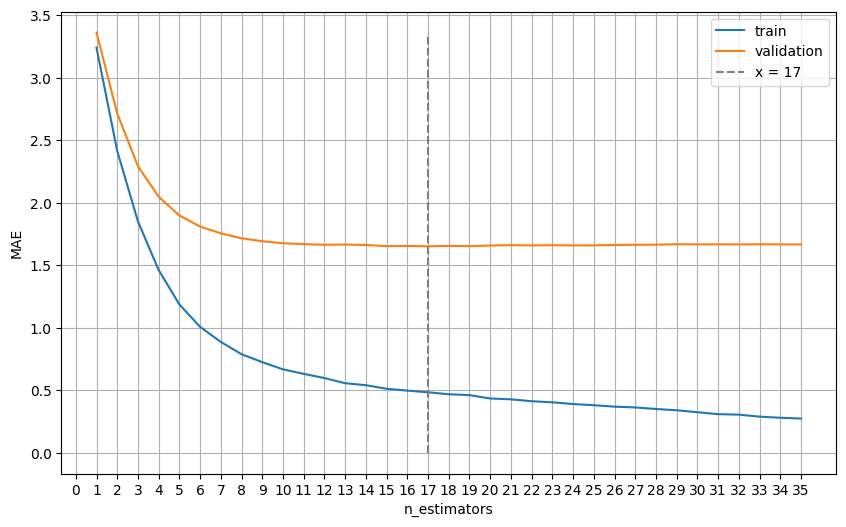

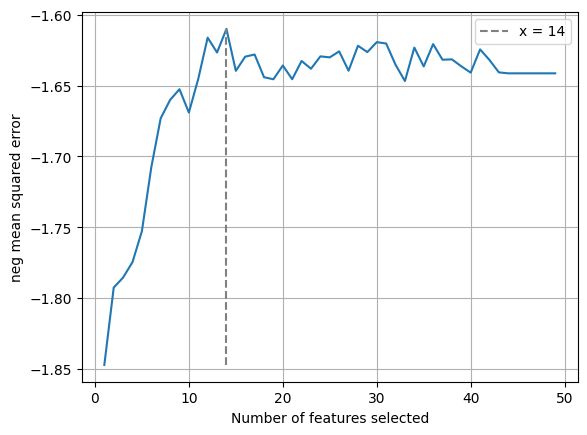

max_depth:  9
Number of estimators:  17
Selected_features:  Index(['DISTANCE_TO_COAST', 'ELEVATION_mean_1km', 'HILLSHADE_mean_1km',
       'FLOW_ACCU_200m', 'null_island_distance', 'days_distance', 'mo_cos',
       'year', 'summer_days_month', 'mosq_sum_month',
       'mosq_sum_month_previous_year', 'mosq_sum_year',
       'mosq_sum_previous_2weeks', 'previous_mosq_measure'],
      dtype='object')
MAE on train set:  0.6115871833084948
min prediction: 0.0
max prediction: 9.0

MAE on test set:  1.6095380029806259
Error <= 3: 89.57 %
min prediction: 0.0
max prediction: 9.0


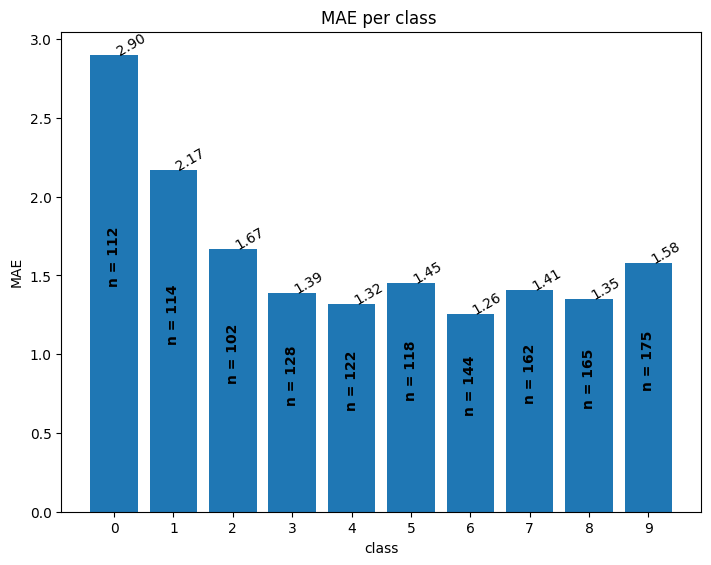

-----------|class error-MAE| difference-----------
mean: 0.3291230942160194
std: 0.364241408460705
coefficient of variation (std/mean): 1.1067026740506876

----------normalized difference-------------
mean: 0.24846175891206634
std: 0.27497329298732115


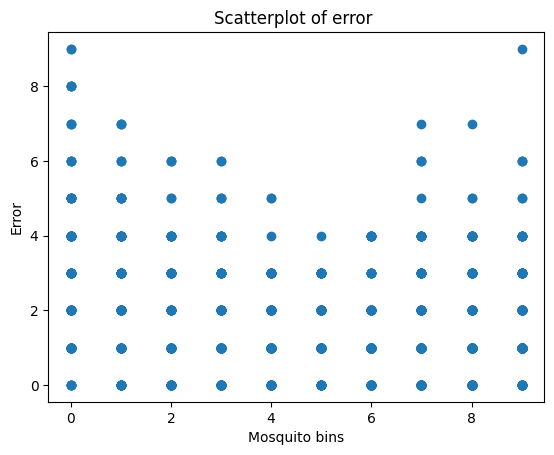

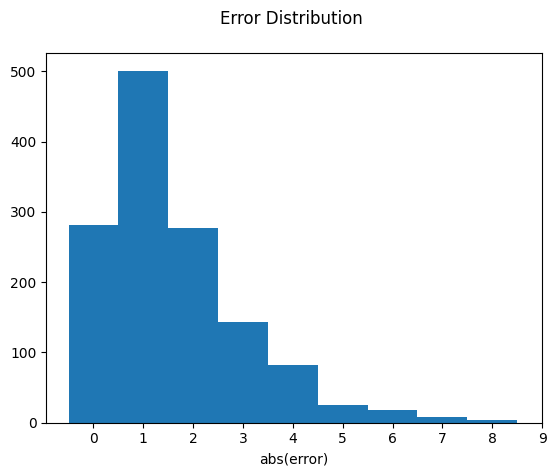

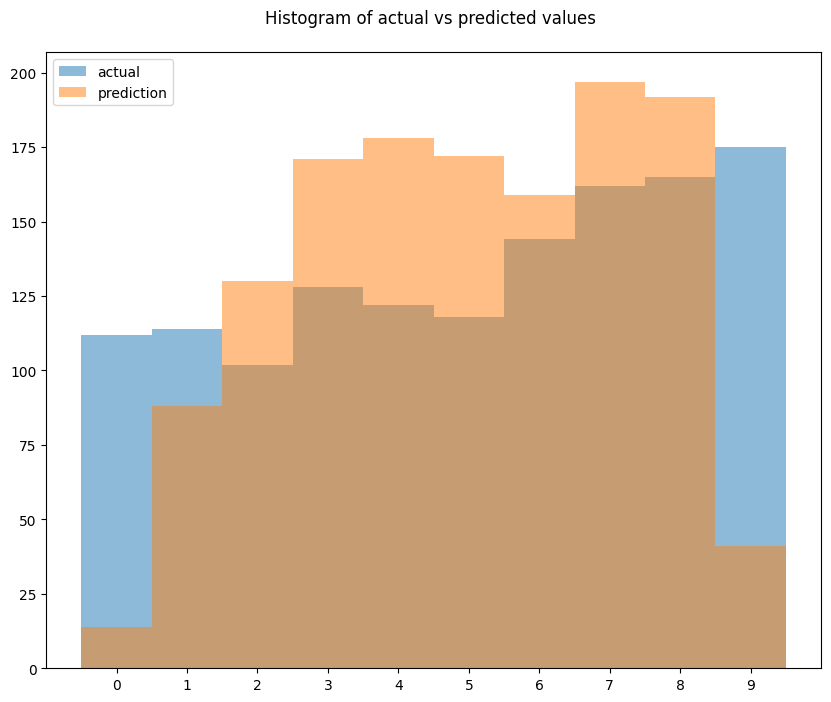

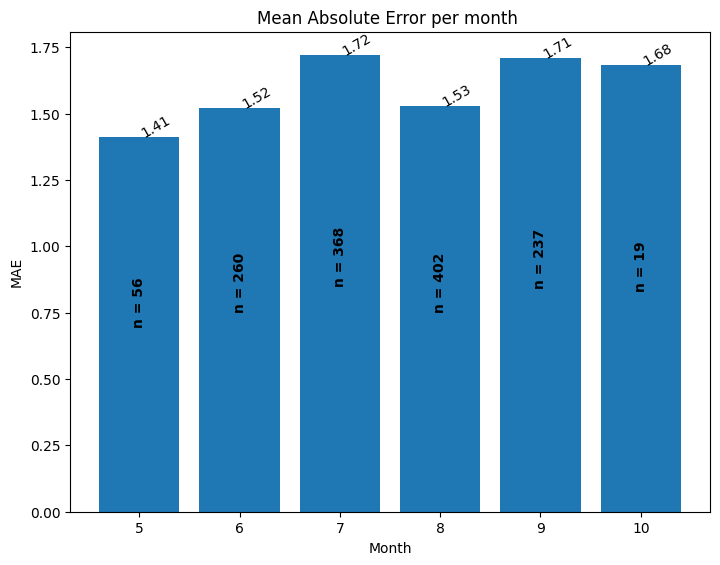

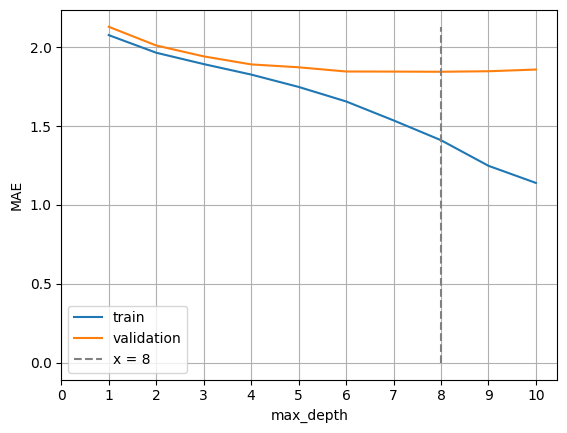

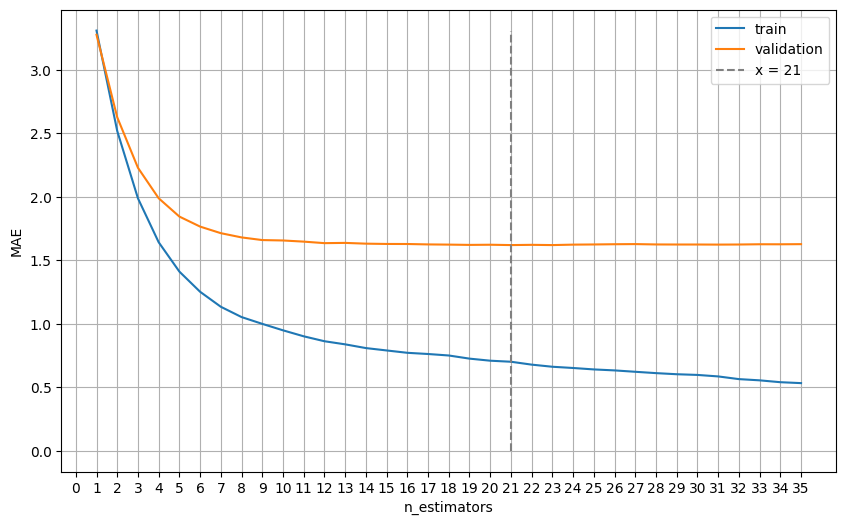

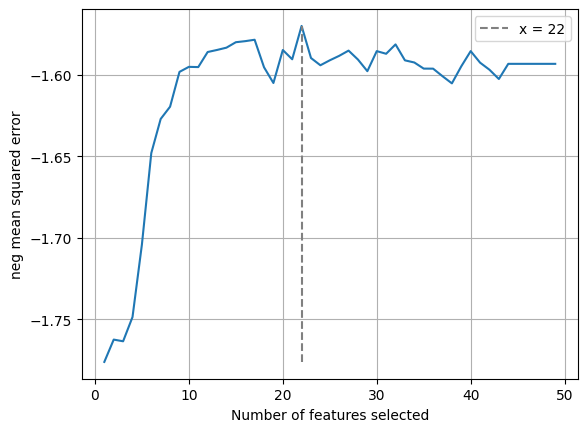

max_depth:  8
Number of estimators:  21
Selected_features:  Index(['lst_mar_night_mean', 'lst_apr_night_mean', 'DISTANCE_TO_COAST',
       'DISTANCE_TO_RIVER', 'SLOPE_mean_1km', 'ASPECT_mean_200m',
       'ELEVATION_mean_1km', 'HILLSHADE_mean_1km', 'FS_AREA_1km',
       'FLOW_ACCU_200m', 'landcover', 'null_island_distance', 'days_distance',
       'mo_cos', 'year', 'lst', 'summer_days_month', 'mosq_sum_month',
       'mosq_sum_month_previous_year', 'mosq_sum_year',
       'mosq_sum_previous_2weeks', 'previous_mosq_measure'],
      dtype='object')
prediction
0.0     2
1.0     2
2.0     6
3.0    13
4.0     3
7.0     1
Name: count, dtype: int64

Low risk category stations: 4
Medium risk category stations: 22
High risk category stations: 1
#===========================================
Predictions with/without entomological features
#===========================================
prediction
0.0     505
1.0    1221
2.0    1205
3.0    1147
4.0     704
5.0     224
6.0      16
7.0       3
Name: cou

In [8]:
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================

# Spit to train and test based on date of predictions
test = data.loc[data[date_col] >= pd.to_datetime(date)]
data = data.loc[data[date_col] < pd.to_datetime(date)]

# Delete from test set stations that are not used during the last 3 years
# test = unused_stations(data, test, period=3)

#Remove features that are more 40% filled with nan values in the test set
data, test = remove_nan_features(data, test, 0.3)

# set the only_env as True if there are no mosquitoes for the forecast month
only_env=None    
if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
    only_env=False
elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
    only_env=True
else:
    print('No data left for prediction')

learning_rate = 0.3
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = []
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance (!very time consuming!)
fi = False
    
if only_env != None:
    # Run first without entomological features
    print("#===========================================")
    print("Predictions without entomological features")
    print("#===========================================")
    print()
    data_env = data.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    
    data_env = data_env.dropna().reset_index(drop=True)
    test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)

    model = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                          embedding_data = embedded_data,  transformation_list = transformation_list,
                          early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)
    
    evaluate_xgboost(model, data_env, fi = fi)

    predictions_env = give_predictions_xgboost(model, data_env, test_env, env = True, filepath = path, case = title,
                                               fi = fi, export = only_env)


    # Run with entomological features if at least one station has mosquitos number
    if not only_env:
        print("#===========================================")
        print("Predictions with entomological features")
        print("#===========================================")
        print()
        
        data_entom = data.dropna().reset_index(drop=True)
        test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        model = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                              embedding_data = embedded_data,  transformation_list = transformation_list,
                              early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)
    
        evaluate_xgboost(model, data_entom, fi = fi)

        predictions_entom = give_predictions_xgboost(model, data_entom, test_entom, env = True, filepath = path,
                                                     fi = fi, case = title, export = only_env)

        print("#===========================================")
        print("Predictions with/without entomological features")
        print("#===========================================")
        merge_predictions(predictions_env,predictions_entom, path, title, export=True)